### 0. Install and Import Dependencies

In [1]:
%pip install mediapipe opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import mediapipe as mp
import cv2

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

### 1. Make Detections

In [4]:
cap = cv2.VideoCapture(0) # the 0 is the camera index, might need change depending on the setup
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
fps = cap.get(cv2.CAP_PROP_FPS)


with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Ignoring empty camera frame.")
            break
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # converting the frame from BGR to RGB
        image.flags.writeable = False # preventing copying the image data
        results = holistic.process(image) # processing the image

        # Recolor image back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
        
        # Draw right hand landmarks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(80,44,10), thickness=2, circle_radius=4))
        
        # Draw left hand landmarks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(80,44,10), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4))
        
        # Draw pose landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(80,44,10), thickness=2, circle_radius=4))
        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@1.196] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1.197] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
I0000 00:00:1711920972.608899   41335 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1711920972.678580   47562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA GeForce RTX 3060/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### 2. Data processing

The dataset was taken from this source: https://www.kaggle.com/code/ayushsaini04/face-expression-recognition-with-deep-learning

All images have a resolution 48x48. The images appearing in the plot are random images of the train dataset.

In [5]:
# input path for the images
base_path = "data/archive/images/"

Let's count the number of images for each facial expression

In [6]:
import os
print("No. of images in the training split: ")
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

print("\nNo. of images in the validation split: ")
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")

No. of images in the training split: 
3205 surprise images
2180 disgust images
7164 happy images
4938 sad images
4103 fear images
4982 neutral images
3993 angry images

No. of images in the validation split: 
797 surprise images
555 disgust images
1825 happy images
1139 sad images
1018 fear images
1216 neutral images
960 angry images


The "disgust" images appear to be much lesser than the other categories. This significant imbalance could potentially cause problems to the model.

A good solution to this issue is to augment the images of the "disgust" dataset, so that we create more samples of this class and thus improve the model's accuracy.

Original: 


/tmp/ipykernel_41335/3631912447.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path + random.choice(os.listdir(disgust_path)))


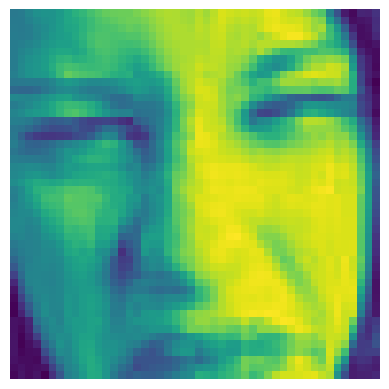

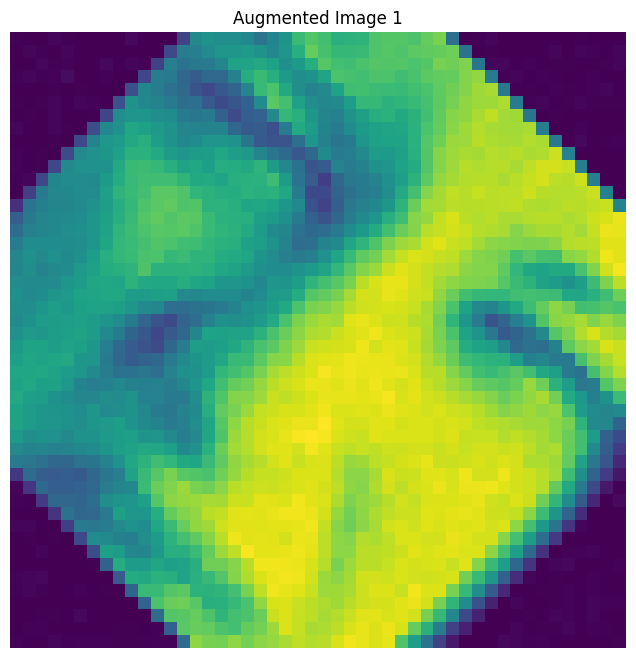

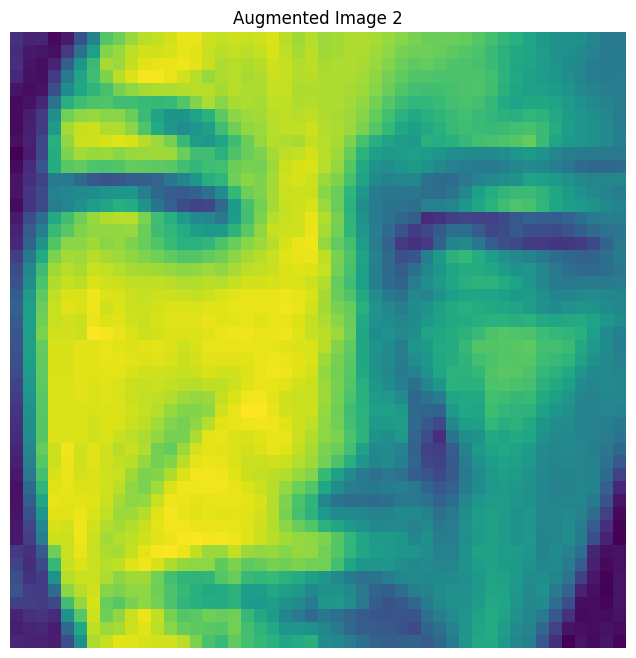

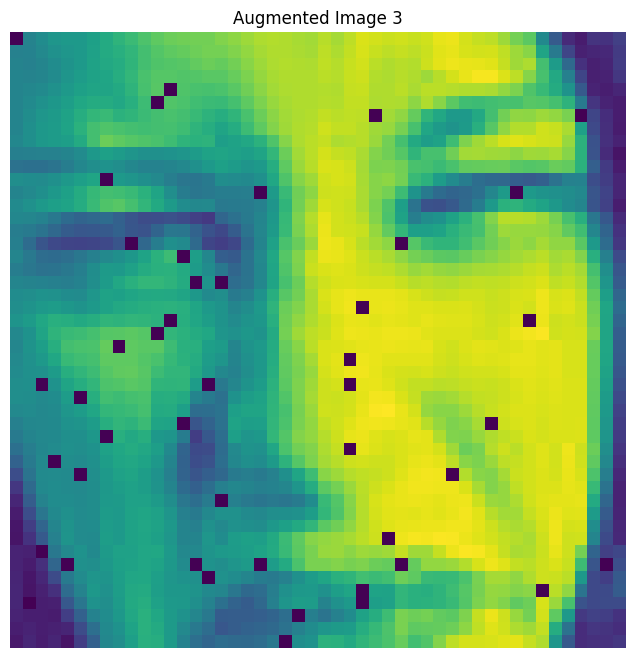

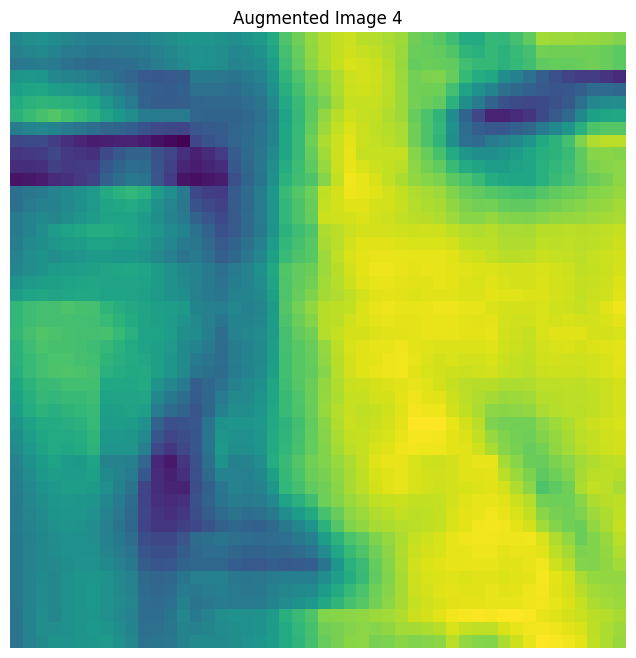

In [7]:
# Load a random image and display it

import imageio
import imgaug as ia
import matplotlib.pyplot as plt
import random

%matplotlib inline

disgust_path = "data/archive/images/train/disgust/"
disgust_path_val = "data/archive/images/validation/disgust/"
image = imageio.imread(disgust_path + random.choice(os.listdir(disgust_path)))

print("Original: ")
plt.imshow(image)
plt.axis('off')
plt.show()


# Augment the Image

from imgaug import augmenters as iaa
ia.seed(4)

# Define different sequential augmenters
seq1 = iaa.Sequential([
    iaa.Affine(rotate=45),
    iaa.AdditiveGaussianNoise(scale=0.01*255)
])

seq2 = iaa.Sequential([
    iaa.Fliplr(1)  # Horizontal flip
])

seq3 = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0.01, 0.05)),
    iaa.Dropout(p=(0.01, 0.05)),
])

seq4 = iaa.Sequential([
    iaa.Crop(percent=(0, 0.2)),  # random crops
    iaa.Sharpen(alpha=(0.01, 0.05))  # sharpen the image
])

# List of all sequentials
sequentials = [seq1, seq2, seq3, seq4]


for i, seq in enumerate(sequentials, start=1):
    # Apply augmentation
    image_aug = seq(image=image)
    
    # Display the augmented image
    plt.figure(figsize=(8, 8))
    plt.imshow(image_aug)
    plt.axis('off')
    plt.title(f'Augmented Image {i}')
    plt.show()

We are going to do the same thing as in the above cell but for all the images in the "disgust" folder, in order to increase the number of samples we are going to use for our training.

(In case we want to delete some of the images we just created, we can run this script)

In [8]:
import os

disgust_path = "data/archive/images/train/disgust/" # add the path here

# List all files in the directory
files_in_directory = os.listdir(disgust_path) 

# Filter for files that end with '_aug.jpg'
files_to_delete = [file for file in files_in_directory if file.endswith('_aug.jpg')]

# Delete the files
for file in files_to_delete:
    os.remove(os.path.join(disgust_path, file))
    print(f"Deleted {file}")


In [9]:
for pic in os.listdir(disgust_path):
    image = imageio.imread(disgust_path + pic)
    for i, seq in enumerate(sequentials, start=1):
        image_aug = seq(image=image)
        imageio.imwrite(os.path.join(disgust_path, pic[:-4] + f"_aug{i}.jpg"), image_aug)
    
for pic in os.listdir(disgust_path_val):
    image = imageio.imread(disgust_path_val + pic)
    for i, seq in enumerate(sequentials, start=1):
        image_aug = seq(image=image)
        imageio.imwrite(os.path.join(disgust_path_val, pic[:-4] + f"_aug{i}.jpg"), image_aug)

/tmp/ipykernel_41335/4002025705.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path + pic)


/tmp/ipykernel_41335/4002025705.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(disgust_path_val + pic)


In [10]:
print("No. of images in the training split: ")
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

print("\nNo. of images in the validation split: ")
for expression in os.listdir(base_path + "validation"):
    print(str(len(os.listdir(base_path + "validation/" + expression))) + " " + expression + " images")

No. of images in the training split: 
3205 surprise images
9156 disgust images
7164 happy images
4938 sad images
4103 fear images
4982 neutral images
3993 angry images

No. of images in the validation split: 
797 surprise images
2331 disgust images
1825 happy images
1139 sad images
1018 fear images
1216 neutral images
960 angry images


Now we see that our dataset is more balanced.

### 3. Training

In [11]:
import torch

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if train_on_gpu else "cpu")
print(f'Using device: {device}')


Using device: cuda


Firstly, we load the dataset with Data Loaders:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


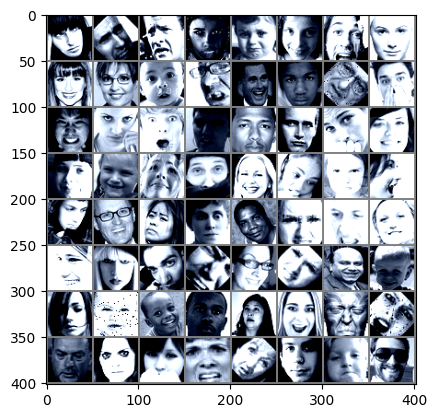

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torchvision import transforms, datasets, utils
from PIL import Image
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the pixel values
])

# input path for the images
base_path = "data/archive/images/"

# defining train dataset
train_dataset = datasets.ImageFolder(root=os.path.join(base_path, "train"), transform=transform)
# defining validation dataset
val_dataset = datasets.ImageFolder(root=os.path.join(base_path, "validation"), transform=transform)

# creating a DataLoader for the train dataset
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

# function to display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of images from train dataset
train_dataiter = iter(train_dataloader)
images, labels = next(train_dataiter)

# show images
imshow(utils.make_grid(images))


Then, we define our model:

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        # Load a pre-trained ResNet-18 model. Inittially, the model is trained on ImageNet dataset
        self.resnet = models.resnet18(pretrained=True)
        
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the fully connected layers of ResNet-18 and use it purely as a feature extractor
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Custom layers
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)  # ResNet-18 features to 256
        self.fc2 = nn.Linear(256, num_classes)  # Final output layer



    def forward(self, x):
        # Feature extraction
        x = self.resnet(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        
        # Custom classifier
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.25, training=self.training)
        x = self.fc2(x)
        return x


For training, we define an optimizer and a loss function, and then we ensure each batch of input data and labels are sent to GPU during our training loop:

In [18]:
import torch.optim as optim
from sklearn.metrics import f1_score

model = EmotionCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss() # Cross-entropy loss for classification problems
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
best_accuracy = 0.0

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device) # transfer image data and labels to GPU
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}')
    scheduler.step()
    
    # Set predictions and labels lists
    all_preds = [] 
    all_labels = []

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device) # tranfer image data and labels to GPU

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for F1 calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    accuracy = 100 * correct / total
    print(f'Accuracy on the validation set: {accuracy}%')

    f1 = f1_score(all_labels, all_preds, average='weighted')  # 'weighted' accounts for label imbalance
    print(f'F1 Score on the validation set: {f1}')

    # Save the model if it has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved new best model")

/home/geokoko/code/ARGLASSES/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/geokoko/code/ARGLASSES/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 1.4373356949734728
Accuracy on the validation set: 54.96446263191902%
F1 Score on the validation set: 0.5368065049216209
Saved new best model
Epoch 2, Loss: 1.091573894531601
Accuracy on the validation set: 59.121257807452075%
F1 Score on the validation set: 0.5831883735046749
Saved new best model
Epoch 3, Loss: 0.8868510542370798
Accuracy on the validation set: 61.01658410510446%
F1 Score on the validation set: 0.607826717000047
Saved new best model
Epoch 4, Loss: 0.703916729968898
Accuracy on the validation set: 61.231962093474046%
F1 Score on the validation set: 0.6136133811317978
Saved new best model
Epoch 5, Loss: 0.527062533331283
Accuracy on the validation set: 62.07193624811544%
F1 Score on the validation set: 0.6242993236546243
Saved new best model
Epoch 6, Loss: 0.3669890316117561
Accuracy on the validation set: 62.59961231962094%
F1 Score on the validation set: 0.629376335655396
Saved new best model
Epoch 7, Loss: 0.2584653068111743
Accuracy on the validation 